In [1]:
#Mandatory imports
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit
from os.path import join as opj
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pylab
plt.rcParams['figure.figsize'] = 10, 10
%matplotlib inline

In [2]:
train = pd.read_json("input/train.json")
target_train=train['is_iceberg']
test = pd.read_json("input/test.json")

In [3]:
target_train=train['is_iceberg']
test['inc_angle']=pd.to_numeric(test['inc_angle'], errors='coerce')
train['inc_angle']=pd.to_numeric(train['inc_angle'], errors='coerce')#We have only 133 NAs.
train['inc_angle']=train['inc_angle'].fillna(method='pad')
X_angle=train['inc_angle']
test['inc_angle']=pd.to_numeric(test['inc_angle'], errors='coerce')
X_test_angle=test['inc_angle']

In [4]:
#Generate the training data
X_band_1=np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in train["band_1"]])
X_band_2=np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in train["band_2"]])
X_band_3=(X_band_1+X_band_2)/2
#X_band_3=np.array([np.full((75, 75), angel).astype(np.float32) for angel in train["inc_angle"]])
X_train = np.concatenate([X_band_1[:, :, :, np.newaxis]
                          , X_band_2[:, :, :, np.newaxis]
                         , X_band_3[:, :, :, np.newaxis]], axis=-1)

In [5]:
X_band_test_1=np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in test["band_1"]])
X_band_test_2=np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in test["band_2"]])
X_band_test_3=(X_band_test_1+X_band_test_2)/2
#X_band_test_3=np.array([np.full((75, 75), angel).astype(np.float32) for angel in test["inc_angle"]])
X_test = np.concatenate([X_band_test_1[:, :, :, np.newaxis]
                          , X_band_test_2[:, :, :, np.newaxis]
                         , X_band_test_3[:, :, :, np.newaxis]], axis=-1)

In [6]:
#Import Keras.
from matplotlib import pyplot
from keras.optimizers import RMSprop
# from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Input, Flatten, Activation
from keras.layers import GlobalMaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers.merge import Concatenate
from keras.models import Model
from keras import initializers
from keras.optimizers import Adam
from keras.optimizers import rmsprop
from keras.layers.advanced_activations import LeakyReLU, PReLU
from keras.optimizers import SGD
from keras.optimizers import Adadelta
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping

from keras.datasets import cifar10
from keras.applications.inception_v3 import InceptionV3
from keras.applications.vgg16 import VGG16
from keras.applications.xception import Xception
from keras.applications.mobilenet import MobileNet
from keras.applications.vgg19 import VGG19
from keras.layers import Concatenate, Dense, LSTM, Input, concatenate
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input

Using TensorFlow backend.


In [7]:
#Data Aug for multi-input
from keras.preprocessing.image import ImageDataGenerator
batch_size=64
# Define the image transformations here
gen = ImageDataGenerator(horizontal_flip = True,
                         vertical_flip = True,
                         width_shift_range = 0.,
                         height_shift_range = 0.,
                         channel_shift_range=0,
                         zoom_range = 0.2,
                         rotation_range = 10)

In [8]:
# Here is the function that merges our two generators
# We use the exact same generator with the same random seed for both the y and angle arrays
def gen_flow_for_two_inputs(X1, X2, y):
    genX1 = gen.flow(X1,y,  batch_size=batch_size,seed=55)
    genX2 = gen.flow(X1,X2, batch_size=batch_size,seed=55)
    while True:
            X1i = genX1.next()
            X2i = genX2.next()
            #Assert arrays are equal - this was for peace of mind, but slows down training
            #np.testing.assert_array_equal(X1i[0],X2i[0])
            yield [X1i[0], X2i[1]], X1i[1]

In [9]:
# Finally create generator
def get_callbacks(filepath, patience=2):
    es = EarlyStopping('val_loss', patience=15, mode="min")
    msave = ModelCheckpoint(filepath, save_best_only=True)
    return [es, msave]

In [10]:
def getVggAngleModel():
    input_2 = Input(shape=[1], name="angle")
    angle_layer = Dense(1, )(input_2)
    base_model = VGG16(weights='imagenet', include_top=False, 
                 input_shape=X_train.shape[1:], classes=1)
    x = base_model.get_layer('block5_pool').output
    

    x = GlobalMaxPooling2D()(x)
    merge_one = concatenate([x, angle_layer])
    merge_one = Dense(512, activation='relu', name='fc2')(merge_one)
    merge_one = Dropout(0.3)(merge_one)
    merge_one = Dense(512, activation='relu', name='fc3')(merge_one)
    merge_one = Dropout(0.3)(merge_one)
    
    predictions = Dense(1, activation='sigmoid')(merge_one)
    
    model = Model(inputs=[base_model.input, input_2], outputs=predictions)
    
    adam = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-8, decay=1e-6, amsgrad=True)
    model.compile(loss='binary_crossentropy',
                    optimizer=adam,
                    metrics=['accuracy'])
    
#     sgd = SGD(lr=1e-3, decay=1e-6, momentum=0.9, nesterov=True)
#     model.compile(loss='binary_crossentropy',
#                   optimizer=sgd,
#                   metrics=['accuracy'])
    return model



In [11]:
#def myAngleCV(X_train, X_angle, X_test):
K=10
folds = list(StratifiedKFold(n_splits=K, shuffle=True, random_state=16).split(X_train, target_train))
y_test_pred_log = 0
y_train_pred_log=0
y_valid_pred_log = 0.0*target_train
for j, (train_idx, test_idx) in enumerate(folds):
    print('\n===================FOLD=',j)
    X_train_cv = X_train[train_idx]
    y_train_cv = target_train[train_idx]
    X_holdout = X_train[test_idx]
    Y_holdout= target_train[test_idx]
    
    #Angle
    X_angle_cv=X_angle[train_idx]
    X_angle_hold=X_angle[test_idx]
    #define file path and get callbacks
    file_path = "%s_aug_model_weights.hdf5"%j
    callbacks = get_callbacks(filepath=file_path, patience=5)
    gen_flow = gen_flow_for_two_inputs(X_train_cv, X_angle_cv, y_train_cv)
    galaxyModel= getVggAngleModel()
    histr = galaxyModel.fit_generator(
            gen_flow,
            steps_per_epoch=24,
            epochs=100,
            shuffle=True,
            verbose=1,
            validation_data=([X_holdout,X_angle_hold], Y_holdout),
            callbacks=callbacks)
     #Getting the Best Model
    galaxyModel.load_weights(filepath=file_path)
    #Getting Training Score
    score = galaxyModel.evaluate([X_train_cv,X_angle_cv], y_train_cv, verbose=0)
    print('Train loss:', score[0])
    print('Train accuracy:', score[1])
    #Getting Test Score
    score = galaxyModel.evaluate([X_holdout,X_angle_hold], Y_holdout, verbose=0)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])

    #Getting validation Score.
    pred_valid=galaxyModel.predict([X_holdout,X_angle_hold])
    y_valid_pred_log[test_idx] = pred_valid.reshape(pred_valid.shape[0])

    #Getting Test Scores
    temp_test=galaxyModel.predict([X_test, X_test_angle])
    y_test_pred_log+=temp_test.reshape(temp_test.shape[0])

    #Getting Train Scores
    temp_train=galaxyModel.predict([X_train, X_angle])
    y_train_pred_log+=temp_train.reshape(temp_train.shape[0])

y_test_pred_log=y_test_pred_log/K
y_train_pred_log=y_train_pred_log/K

print('\n Train Log Loss Validation= ',log_loss(target_train, y_train_pred_log))
print(' Test Log Loss Validation= ',log_loss(target_train, y_valid_pred_log))
#return y_test_pred_log


===================FOLD= 0
Epoch 1/100
24/24 [==============================] - 19s 810ms/step - loss: 0.8344 - acc: 0.6125 - val_loss: 0.3930 - val_acc: 0.8025
Epoch 2/100
24/24 [==============================] - 14s 589ms/step - loss: 0.5746 - acc: 0.7654 - val_loss: 0.3571 - val_acc: 0.8519
Epoch 3/100
24/24 [==============================] - 14s 587ms/step - loss: 0.4330 - acc: 0.8104 - val_loss: 0.2860 - val_acc: 0.8519
Epoch 4/100
24/24 [==============================] - 14s 590ms/step - loss: 0.4494 - acc: 0.8266 - val_loss: 0.2788 - val_acc: 0.8519
Epoch 5/100
24/24 [==============================] - 14s 590ms/step - loss: 0.3594 - acc: 0.8406 - val_loss: 0.2568 - val_acc: 0.8765
Epoch 6/100
24/24 [==============================] - 14s 593ms/step - loss: 0.3168 - acc: 0.8752 - val_loss: 0.2468 - val_acc: 0.9012
Epoch 7/100
24/24 [==============================] - 12s 514ms/step - loss: 0.2897 - acc: 0.8799 - val_loss: 0.2627 - val_acc: 0.8951
Epoch 8/100
24/24 [===============

24/24 [==============================] - 13s 521ms/step - loss: 0.1558 - acc: 0.9405 - val_loss: 0.2571 - val_acc: 0.9255
Epoch 28/100
24/24 [==============================] - 13s 523ms/step - loss: 0.1575 - acc: 0.9319 - val_loss: 0.2043 - val_acc: 0.9379
Epoch 29/100
24/24 [==============================] - 13s 522ms/step - loss: 0.1548 - acc: 0.9345 - val_loss: 0.2350 - val_acc: 0.9130
Epoch 30/100
24/24 [==============================] - 12s 521ms/step - loss: 0.1455 - acc: 0.9338 - val_loss: 0.3066 - val_acc: 0.9130
Train loss: 0.158117664166
Train accuracy: 0.936243936244
Test loss: 0.156742053905
Test accuracy: 0.944099378882

===================FOLD= 2
Epoch 1/100
24/24 [==============================] - 16s 678ms/step - loss: 0.7010 - acc: 0.5746 - val_loss: 0.5068 - val_acc: 0.7205
Epoch 2/100
24/24 [==============================] - 14s 603ms/step - loss: 0.5963 - acc: 0.6657 - val_loss: 0.4875 - val_acc: 0.7640
Epoch 3/100
24/24 [==============================] - 14s 603ms/

Epoch 57/100
24/24 [==============================] - 13s 525ms/step - loss: 0.1094 - acc: 0.9562 - val_loss: 0.2329 - val_acc: 0.9130
Epoch 58/100
24/24 [==============================] - 13s 525ms/step - loss: 0.0973 - acc: 0.9617 - val_loss: 0.2349 - val_acc: 0.9068
Epoch 59/100
24/24 [==============================] - 13s 526ms/step - loss: 0.1068 - acc: 0.9519 - val_loss: 0.2156 - val_acc: 0.9193
Epoch 60/100
24/24 [==============================] - 13s 526ms/step - loss: 0.0685 - acc: 0.9760 - val_loss: 0.2742 - val_acc: 0.8944
Epoch 61/100
24/24 [==============================] - 13s 522ms/step - loss: 0.0712 - acc: 0.9721 - val_loss: 0.3162 - val_acc: 0.9255
Epoch 62/100
24/24 [==============================] - 13s 523ms/step - loss: 0.0813 - acc: 0.9659 - val_loss: 0.3132 - val_acc: 0.9068
Train loss: 0.0521078983055
Train accuracy: 0.979902979903
Test loss: 0.146851015757
Test accuracy: 0.950310559006

===================FOLD= 3
Epoch 1/100
24/24 [============================

Epoch 4/100
24/24 [==============================] - 15s 612ms/step - loss: 0.3801 - acc: 0.8257 - val_loss: 0.1913 - val_acc: 0.9375
Epoch 5/100
24/24 [==============================] - 15s 610ms/step - loss: 0.3338 - acc: 0.8409 - val_loss: 0.1762 - val_acc: 0.9437
Epoch 6/100
24/24 [==============================] - 13s 530ms/step - loss: 0.3038 - acc: 0.8787 - val_loss: 0.2105 - val_acc: 0.9125
Epoch 7/100
24/24 [==============================] - 13s 529ms/step - loss: 0.2952 - acc: 0.8739 - val_loss: 0.2261 - val_acc: 0.9313
Epoch 8/100
24/24 [==============================] - 13s 528ms/step - loss: 0.2707 - acc: 0.8829 - val_loss: 0.1885 - val_acc: 0.9250
Epoch 9/100
24/24 [==============================] - 13s 530ms/step - loss: 0.2727 - acc: 0.8849 - val_loss: 0.1841 - val_acc: 0.9375
Epoch 10/100
24/24 [==============================] - 13s 530ms/step - loss: 0.3052 - acc: 0.8617 - val_loss: 0.2046 - val_acc: 0.9187
Epoch 11/100
24/24 [==============================] - 13s 529

Train loss: 0.114420213115
Train accuracy: 0.95567867036
Test loss: 0.172631277144
Test accuracy: 0.95625

===================FOLD= 6
Epoch 1/100
24/24 [==============================] - 17s 717ms/step - loss: 0.6845 - acc: 0.5821 - val_loss: 0.6529 - val_acc: 0.5687
Epoch 2/100
24/24 [==============================] - 15s 604ms/step - loss: 0.5061 - acc: 0.7125 - val_loss: 0.4422 - val_acc: 0.7438
Epoch 3/100
24/24 [==============================] - 14s 597ms/step - loss: 0.3777 - acc: 0.8062 - val_loss: 0.3518 - val_acc: 0.8063
Epoch 4/100
24/24 [==============================] - 13s 522ms/step - loss: 0.3137 - acc: 0.8432 - val_loss: 0.3655 - val_acc: 0.8250
Epoch 5/100
24/24 [==============================] - 13s 522ms/step - loss: 0.2709 - acc: 0.8728 - val_loss: 0.3806 - val_acc: 0.8562
Epoch 6/100
24/24 [==============================] - 13s 522ms/step - loss: 0.3148 - acc: 0.8409 - val_loss: 0.3755 - val_acc: 0.8063
Epoch 7/100
24/24 [==============================] - 14s 603ms

Epoch 11/100
24/24 [==============================] - 12s 519ms/step - loss: 0.2358 - acc: 0.9020 - val_loss: 0.2068 - val_acc: 0.8812
Epoch 12/100
24/24 [==============================] - 14s 599ms/step - loss: 0.2314 - acc: 0.9005 - val_loss: 0.1888 - val_acc: 0.9187
Epoch 13/100
24/24 [==============================] - 12s 519ms/step - loss: 0.2166 - acc: 0.9039 - val_loss: 0.2368 - val_acc: 0.9000
Epoch 14/100
24/24 [==============================] - 12s 520ms/step - loss: 0.2444 - acc: 0.8980 - val_loss: 0.2092 - val_acc: 0.9250
Epoch 15/100
24/24 [==============================] - 14s 597ms/step - loss: 0.2099 - acc: 0.9130 - val_loss: 0.1870 - val_acc: 0.9125
Epoch 16/100
24/24 [==============================] - 12s 520ms/step - loss: 0.2216 - acc: 0.9124 - val_loss: 0.1910 - val_acc: 0.9000
Epoch 17/100
24/24 [==============================] - 12s 519ms/step - loss: 0.1644 - acc: 0.9409 - val_loss: 0.2312 - val_acc: 0.8875
Epoch 18/100
24/24 [==============================] - 1

Epoch 34/100
24/24 [==============================] - 13s 527ms/step - loss: 0.1284 - acc: 0.9498 - val_loss: 0.4157 - val_acc: 0.8562
Epoch 35/100
24/24 [==============================] - 13s 528ms/step - loss: 0.1517 - acc: 0.9436 - val_loss: 0.4794 - val_acc: 0.8187
Train loss: 0.135388263395
Train accuracy: 0.948060941828
Test loss: 0.307810878754
Test accuracy: 0.8625

===================FOLD= 9
Epoch 1/100
24/24 [==============================] - 18s 753ms/step - loss: 0.7067 - acc: 0.5664 - val_loss: 0.6313 - val_acc: 0.6062
Epoch 2/100
24/24 [==============================] - 15s 609ms/step - loss: 0.5009 - acc: 0.7520 - val_loss: 0.4025 - val_acc: 0.8125
Epoch 3/100
24/24 [==============================] - 15s 611ms/step - loss: 0.4177 - acc: 0.8142 - val_loss: 0.3420 - val_acc: 0.8375
Epoch 4/100
24/24 [==============================] - 15s 609ms/step - loss: 0.3751 - acc: 0.8329 - val_loss: 0.3069 - val_acc: 0.8562
Epoch 5/100
24/24 [==============================] - 15s 608

In [12]:
#preds=myAngleCV(X_train, X_angle, X_test)
preds = y_test_pred_log

In [13]:
# Submission to kaggle
submission = pd.DataFrame()
submission['id']=test['id']
submission['is_iceberg']=preds
submission.to_csv('sub_Adam_10folds_amsgrad_0001_15p_5nd.csv', index=False)

dict_keys(['val_acc', 'loss', 'acc', 'val_loss'])


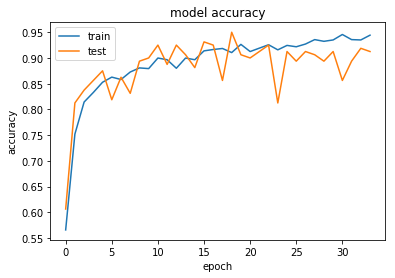

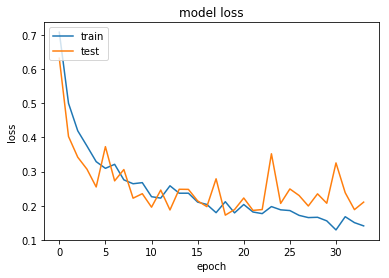

In [14]:
# list all data in history
print(histr.history.keys())
# summarize history for accuracy
plt.plot(histr.history['acc'])
plt.plot(histr.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(histr.history['loss'])
plt.plot(histr.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

---

In [15]:
import matplotlib.image as mpimg

min1 = np.min(X_holdout)
max1 = np.max(X_holdout)
diff1 = max1 - min1
my_sum = lambda x: (x - min1)/diff1

X_holdout2 = my_sum(X_holdout)

In [16]:
Y_holdout

13      1
14      0
38      1
43      0
44      0
80      0
104     1
127     0
137     0
138     1
141     1
167     1
195     1
199     0
207     1
212     0
213     1
221     0
240     0
256     0
267     1
274     1
276     1
285     1
290     0
294     0
300     1
307     1
311     1
318     1
       ..
1363    1
1364    0
1373    1
1380    1
1394    0
1411    0
1435    0
1440    1
1445    1
1447    1
1460    1
1470    0
1488    0
1495    0
1504    1
1516    0
1525    0
1533    0
1537    0
1539    0
1541    0
1542    0
1549    0
1552    0
1559    0
1566    0
1567    0
1577    0
1590    0
1602    0
Name: is_iceberg, Length: 160, dtype: int64

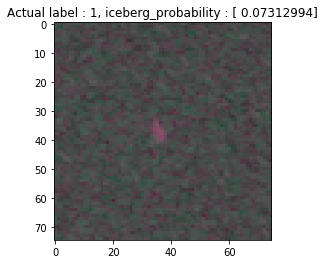

In [17]:
plt.imshow(X_holdout2[0], cmap='gray', interpolation='nearest');
tl = "Actual label : " +str(Y_holdout[13])+ ","+" iceberg_probability : "+str(pred_valid[0])
plt.title(tl)

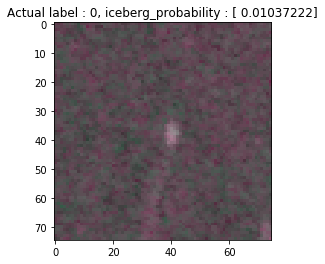

In [18]:
plt.imshow(X_holdout2[1], cmap='gray', interpolation='nearest');
tl = "Actual label : " +str(Y_holdout[14])+ ","+" iceberg_probability : "+str(pred_valid[1])
plt.title(tl)

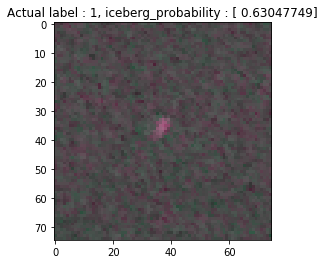

In [19]:
plt.imshow(X_holdout2[2], cmap='gray', interpolation='nearest');
tl = "Actual label : " +str(Y_holdout[38])+ ","+" iceberg_probability : "+str(pred_valid[2])
plt.title(tl)

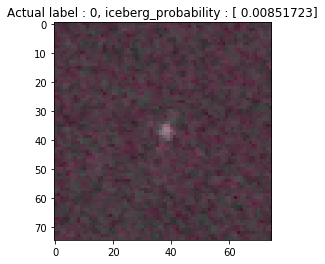

In [20]:
plt.imshow(X_holdout2[3], cmap='gray', interpolation='nearest');
tl = "Actual label : " +str(Y_holdout[43])+ ","+" iceberg_probability : "+str(pred_valid[3])
plt.title(tl)

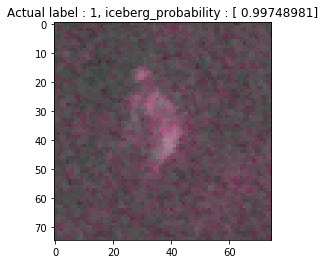

In [21]:
plt.imshow(X_holdout2[6], cmap='gray', interpolation='nearest');
tl = "Actual label : " +str(Y_holdout[104])+ ","+" iceberg_probability : "+str(pred_valid[6])
plt.title(tl)

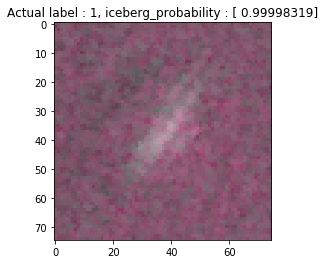

In [22]:
plt.imshow(X_holdout2[9], cmap='gray', interpolation='nearest');
tl = "Actual label : " +str(Y_holdout[138])+ ","+" iceberg_probability : "+str(pred_valid[9])
plt.title(tl)

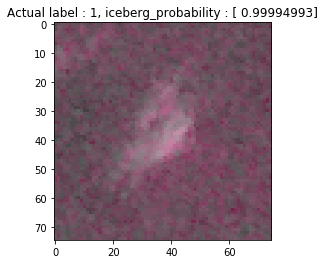

In [23]:
plt.imshow(X_holdout2[10], cmap='gray', interpolation='nearest');
tl = "Actual label : " +str(Y_holdout[141])+ ","+" iceberg_probability : "+str(pred_valid[10])
plt.title(tl)

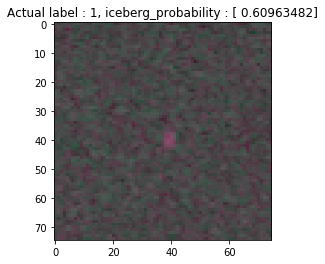

In [24]:
plt.imshow(X_holdout2[11], cmap='gray', interpolation='nearest');
tl = "Actual label : " +str(Y_holdout[167])+ ","+" iceberg_probability : "+str(pred_valid[11])
plt.title(tl)

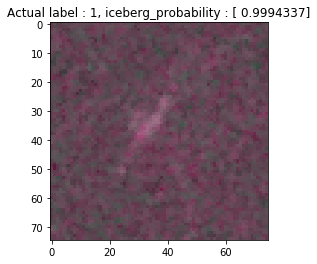

In [25]:
plt.imshow(X_holdout2[12], cmap='gray', interpolation='nearest');
tl = "Actual label : " +str(Y_holdout[195])+ ","+" iceberg_probability : "+str(pred_valid[12])
plt.title(tl)

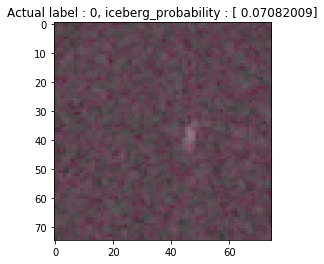

In [26]:
plt.imshow(X_holdout2[13], cmap='gray', interpolation='nearest');
tl = "Actual label : " +str(Y_holdout[199])+ ","+" iceberg_probability : "+str(pred_valid[13])
plt.title(tl)